In [1]:
import torch
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

from neural import QVAE


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cpu


## Data Loaders

In [3]:
BATCH_SIZE = 128
SHUFFLE = True
NUM_WORKERS = 12

In [4]:
train_set_loader = data.DataLoader(
    datasets.MNIST('./data', train=True, transform=transforms.ToTensor(), download=True),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE,
    num_workers=NUM_WORKERS,
)

test_set_loader = data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.ToTensor(), download=True),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE,
    num_workers=NUM_WORKERS,
)

## Net

In [7]:
net = QVAE(
    in_channels=1,
    num_hiddens=32,
    num_res_hiddens=0,
    num_res_layers=0,
    rgb_out=False,
).to(device)

In [8]:
try:
    net.load_state_dict(torch.load(open('state_dict.pth', 'rb')))
    print('State Dict loaded from \'state_dict.pth\'')
except:
    pass

## Train Loop

In [9]:
optimizer = optim.Adam(net.parameters(), lr=1e-2)

In [10]:
def train(epochs=10):
    print('='*10, end='')
    print(' TRAIN', end=' ') 
    print('='*10, end='\n\n')
    net.train()

    for epoch in range(1, epochs+1):
        running_loss = 0

        for i, batch in enumerate(train_set_loader, 1):
            images, _ = batch
            images = images.to(device)
            
            # Zero grad
            optimizer.zero_grad()

            # Forward
            encoded, quantized, recon_x = net(images)
            # Compute Loss
            loss_value = net.loss_function(images, recon_x, encoded, quantized)
            running_loss += loss_value.item()
            # Backward
            loss_value.backward()
            # Update
            optimizer.step()

            if i % 100 == 0:
                print(f'==> EPOCH[{epoch}]({i}/{len(train_set_loader)}): LOSS: {loss_value.item()}')
            
        print(f'=====> EPOCH[{epoch}] Completed: Avg. LOSS: {running_loss/len(train_set_loader)}')
        print()
        
    net.eval()


In [11]:
train()

========== TRAIN ==========

==> EPOCH[1](100/469): LOSS: 0.09839844703674316
==> EPOCH[1](200/469): LOSS: 0.0843266025185585
==> EPOCH[1](300/469): LOSS: 0.07667625695466995
==> EPOCH[1](400/469): LOSS: 0.07573133707046509
=====> EPOCH[1] Completed: Avg. LOSS: 0.10011284699889897

==> EPOCH[2](100/469): LOSS: 0.07628166675567627


KeyboardInterrupt: 

In [14]:
net.quantizer.num_embeddings

332

In [15]:
net.eval()

QVAE(
  (encoder): ResEncoder(
    (conv_1): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (res_stack): ResStack(
      (res_layers): ModuleList()
    )
  )
  (pre_qunatization_conv): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
  (quantizer): Quantizer(
    (embeddings): Embedding(1, 8)
  )
  (decoder): ResDecoder(
    (conv_1): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (res_stack): ResStack(
      (res_layers): ModuleList()
    )
    (conv_trans_1): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_trans_2): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [16]:
net.training

False

1


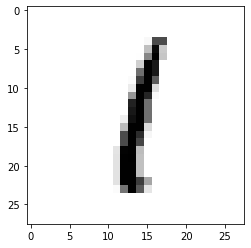

In [67]:
image, label = test_set_loader.dataset[430]
encoded, quantized, recon = net(image.unsqueeze(0))

print(label)
plt.imshow(image[0], cmap='Greys');

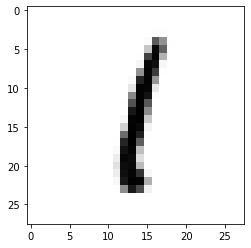

In [68]:
recon = recon[0].squeeze()
plt.imshow(recon.detach().numpy(), cmap='Greys');

In [ ]:
torch.save(net.state_dict(), open('state_dict.pth', 'wb'))